# IO ECO 7408: Problem Set 1 – Binary Logit Demand Estimation for Ride-Sharing Services
## Instructor: Prof. Douglas Turner
## Student: C.H.

In [79]:
globals().clear()

In [80]:
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from scipy.optimize import minimize

import matplotlib.pyplot as plt

## Questions

### 1. Data Setup and Variable Construction

(a) Load the dataset into Python using pandas. Print the first few rows to inspect the data.

In [81]:
df = pd.read_csv('/Users/terrylu/Desktop/UF/Courses/2025-2026/IO/IO_Code/data/uber_data.csv')

print(df.head(5))

   wait_time_uber  wait_time_lyft  price_uber  price_lyft  age  choice_is_uber
0       18.528105       15.619448    8.296000   26.216232   29               1
1       15.800314       13.525088   15.646098   16.062803   38               0
2       16.957476       11.926160   18.613206   21.884515   53               1
3       19.481786       13.875490   23.575972   20.009804   50               0
4       18.735116       11.800978    9.246689   24.669068   21               1


(b) Construct the following new variables:

    • wait_diff: Uber wait time minus Lyft wait time
    • price_diff: Uber price minus Lyft price
    
Also include choice_is_uber in your dataframe.

Hint: A more positive value of wait_diff or price_diff implies Uber is worse than lyft in that attribute.

In [82]:
df['wait_diff'] = df['wait_time_uber'] - df['wait_time_lyft']
df['price_diff'] = df['price_uber'] - df['price_lyft']

### 2. Estimating the Logit Model by Hand
(a) Using only numpy and scipy.optimize.minimize, estimate a binary logit model of the form:

Write out the log-likelihood function manually and optimize it using BFGS.

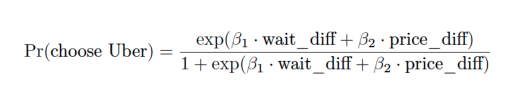

In [83]:
img = plt.imread('/Users/terrylu/Desktop/UF/Courses/2025-2026/IO/IO_Code/Pics/1.1.png')
plt.imshow(img); plt.axis("off");


Write out the log-likelihood function manually and optimize it using BFGS.

In [84]:
y = df['choice_is_uber']
X = df[['wait_diff', 'price_diff']]


def log_likelihood(beta): # define the log-likelihood function
    
    V = X @ beta  # systematic utility

    P = np.exp(V) / (1 + np.exp(V))

    # avoid log(0)
    esp = 1e-12
    P = np.clip(P, esp, 1-esp)  
    
    # log-likelihood
    ll = y * np.log(P) + (1 - y) * np.log(1 - P)
    
    return -np.sum(ll)  # negative log-likelihood for minimization


# initial guess for beta
beta_init = np.zeros(X.shape[1])

# optimize the log-likelihood function
result_1 = minimize(log_likelihood, beta_init, method = 'BFGS')

(b) Report the estimated coefficients. Do the signs of the estimates make sense? Why?

In [85]:

# print the results
beta_hat_1 = result_1.x
print(f"Estimated coefficients (by hand):\n{beta_hat_1}")

Estimated coefficients (by hand):
[-0.5241069  -2.03895639]


Yes, those coedfficients make sence. 

Both of them are negative, which inflects that, longer waiting time and higher price will decrease the probalibity of uber being chosen.

(c) Why can’t age be included in the above model?

Because of the endogeneity.

Of course, age can affect utility. 

But the model also has an error term, which in fact captures many unobserved or omitted variables, for example: 

1. how user-friendly the platform is for older people. 
   
2. whether the platform supports credit cards (which may matter more for adults). 

Since these factors are correlated with age, including age directly in the model would lead to endogeneity problems.


### 3. Estimation Using statsmodels

(a) Re-estimate the same binary logit model using statsmodels.Logit. Compare the results with your manual implementation. Hint: They should be similar if done correctly. Due to numerical differences, they may not be exactly the same.

In [92]:
logit_model_1 = Logit(y, X)

logit_result_1 = logit_model_1.fit(disp=1)

print("\n\nEstimation Using statsmodels\n\n\n",logit_result_1.summary())

Optimization terminated successfully.
         Current function value: 0.066951
         Iterations 12


Estimation Using statsmodels


                            Logit Regression Results                           
Dep. Variable:         choice_is_uber   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4998
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                  0.9033
Time:                        14:53:02   Log-Likelihood:                -334.75
converged:                       True   LL-Null:                       -3463.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
wait_diff     -0.5241      0.047    -11.167      0.000      -0.616      -

In [101]:
### With Robust Covariance Matrix

logit_result_2_robut = logit_model_1.fit(disp=1, cov_type='HC0')

print("\n\nEstimation Using Statsmodels With Robust Covariance Matrix \n\n\n",logit_result_2_robut.summary())

Optimization terminated successfully.
         Current function value: 0.066951
         Iterations 12


Estimation Using Statsmodels With Robust Covariance Matrix 


                            Logit Regression Results                           
Dep. Variable:         choice_is_uber   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4998
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                  0.9033
Time:                        15:02:47   Log-Likelihood:                -334.75
converged:                       True   LL-Null:                       -3463.0
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
wait_diff     -0.5241      0.049    -10.59

Almost the same.

(b) What is the implied willingness to wait one fewer minute (in dollars)? 

Hint: Think about how much a consumer is willing to pay to save a minute of wait time.

"Willingness to wait one fewer minute (in dollars) means": keeping the overall utility unchanged, if time increases by one minute, then the price must decrease by how much?

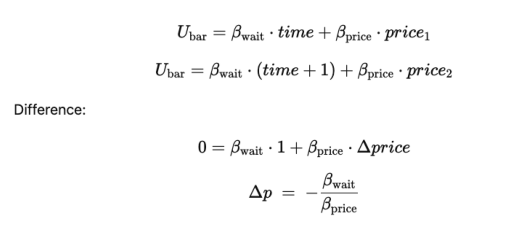

In [95]:
img = plt.imread('/Users/terrylu/Desktop/UF/Courses/2025-2026/IO/IO_Code/Pics/1.2.png')
plt.imshow(img); plt.axis("off");

In [99]:
beta_wait  = logit_result_2_roubut.params['wait_diff']
beta_price = logit_result_2_roubut.params['price_diff']


delta_price =  - (beta_wait / beta_price)
print(f"The implied willingness to wait one fewer minute (in dollars) is: {delta_price:.4f}")

The implied willingness to wait one fewer minute (in dollars) is: -0.2570


### 4. Re-estimate with a Product Fixed Effect

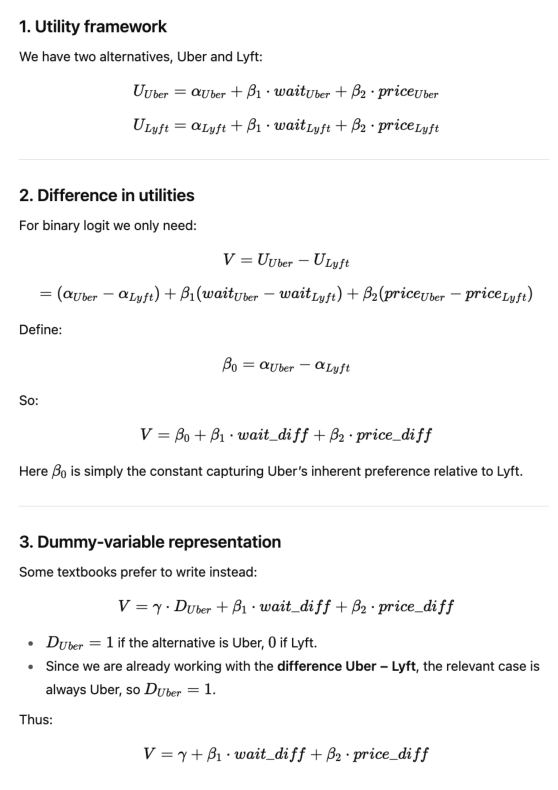

In [106]:
img = plt.imread('/Users/terrylu/Desktop/UF/Courses/2025-2026/IO/IO_Code/Pics/1.3.png')
plt.figure(figsize=(10, 10)) 
plt.imshow(img); plt.axis("off");

(a) Re-estimate the logit model, this time including a dummy variable which is 1 if the product is uber and 0 for lyft.

In [108]:
X_inter = sm.add_constant(df[['wait_diff', 'price_diff']])

logit_model_2 = Logit(y, X_inter)

logit_result_2 = logit_model_2.fit(disp=1)

print("\n\nEstimation with Interception\n\n\n",logit_result_2.summary())

Optimization terminated successfully.
         Current function value: 0.066753
         Iterations 12


Estimation with Interception


                            Logit Regression Results                           
Dep. Variable:         choice_is_uber   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4997
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                  0.9036
Time:                        15:46:21   Log-Likelihood:                -333.77
converged:                       True   LL-Null:                       -3463.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1384      0.099      1.401      0.161      -0.055       

(b) Why might it be important to include this dummy in the model? What does the intercept capture?

Without the intercept, the model forces the probability of choosing Uber to be 0.5 when wait_diff=0 and price_diff=0.

With the intercept, the model allows for this baseline preference to differ from 0.5.

For example, the intercept here is 0.1384, which means that when wait_diff=0 and price_diff=0, the probability of choosing Uber is 0.5345, which is greater than 0.5. Which indicates that, Uber has a slight baseline preference advantage over Lyft.

### 5. Prediction

Suppose an individual faces the following options:

• Uber: 22-minute wait, $7

• Lyft: 14-minute wait, $10

(a) Construct the appropriate values for wait_diff and price_diff.

In [ ]:
wait_diff_pre = 22 - 14

price_diff_pre = 7 - 10

(b) Use your most recent model (with the intercept) to predict the probability that the individual chooses Lyft.

In [111]:
x_pre = [[1,wait_diff_pre, price_diff_pre]]

y_pre = logit_result_2.predict(x_pre)

print(f"predictd probability:\n {y_pre}")

predictd probability:
 [0.88823384]


### 6. Heterogeneity by Age

(a) Add a new interaction term age_wait_diff equal to wait_diff * age.

In [112]:
df['age_wait_diff'] = df['wait_diff'] * df['age']

(b) Re-estimate the model using wait_diff, price_diff, and age_wait_diff (plus a constant).

In [114]:
x_6 = df[['wait_diff', 'price_diff', 'age_wait_diff']]
x_6 = sm.add_constant(x_6)

logit_model_6 = Logit(y, x_6)
logit_result_6 = logit_model_6.fit(disp=0)
print("Estimation with Age & Interaction\n\n\n",logit_result_6.summary())

Estimation with Age & Interaction


                            Logit Regression Results                           
Dep. Variable:         choice_is_uber   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4996
Method:                           MLE   Df Model:                            3
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                  0.9036
Time:                        16:04:38   Log-Likelihood:                -333.76
converged:                       True   LL-Null:                       -3463.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1386      0.099      1.402      0.161      -0.055       0.332
wait_diff        -0.5323      0.115     -4.649      0.000      -0.757      -0.308
pri

The coefficient on age_wait_diff is close to zero and statistically insignificant. 

This implies that in this dataset, the effect of wait time on the probability of choosing Uber does not vary systematically with age.

### 7. Reflection

(a) Suppose a third option was added to the dataset. Specifically, suppose consumers also had the option of choosing uber black (a premium version of uber). Briefly explain one limitation of the logit model in this context.

One limitation of the logit model is the IIA (Independence of Irrelevant Alternatives) assumption: the relative choice probability between any two options does not change when a third option is added or removed. 

In other words, in the logit model, the choice share between Uber and Lyft would remain the same regardless of whether Uber Black exists.

However, In reality, this assumption clearly does not hold, because Uber Black is much closer a substitute to Uber than to Lyft (they are available within the same app). As a result, many consumers who originally chose Uber would likely switch to Uber Black, rather than randomly switching away from both Uber and Lyft. However, the logit model would incorrectly predict that the introduction of Uber Black takes market share proportionally from both Uber and Lyft, which is unrealistic.